# Notebook to make Fig. 4

In [0]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import imageio
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('colorblind')
cp2 = sns.color_palette('pastel')

from helper_functions import *

import sys
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

### Load data

In [25]:
## TODO: finalize this with the real output dir
data_dir = '/Users/smiller/Documents/gw190521-timedomain-release/data_simonas_laptop/' 

angles_vs_time_dict =  np.load(data_dir+'angles_vs_time_dict.npy', allow_pickle=True).item()

In [26]:
# Reconstruction dict has the posterior values stored in it 
reconstruction_dict = np.load(data_dir+"waveform_reconstructions_L1.npy",allow_pickle=True).item()

In [28]:
reconstruction_dict[f'rd m10M']['params']

array([(271.71801715, 0.93556239, 0.67090314, 0.37391317, 3.28425143e+00, 1.16006047, 2.32387098, 4.36236379, 4021.25221259, -1.5786638 , 0.49536803, 0.54842808, -542.79534934,  0.93621279),
       (279.00819697, 0.88078056, 0.39505506, 0.49224846, 6.49243538e-01, 1.27117496, 0.71801467, 5.7928173 , 4334.01733894, -0.00539136, 0.58502903, 0.49438562, -546.3075232 ,  0.93110578),
       (285.58475558, 0.86596645, 0.64992323, 0.5455191 , 2.03696543e-01, 1.39979377, 0.97334852, 3.29519176, 5592.20672246,  0.97959605, 0.43768863, 0.42804144, -548.5251584 , -3.04880903),
       ...,
       (282.81245887, 0.71643829, 0.71246972, 0.71500691, 3.37828792e+00, 1.48080365, 0.95307434, 5.99638496, 6184.18306188, -0.53037143, 0.54412625, 0.71135288, -544.83124822,  2.27411295),
       (272.46870902, 0.85070295, 0.76939354, 0.085299  , 1.21847857e+00, 1.12096999, 2.13681354, 4.65616848, 6591.82248155,  0.39993408, 2.85021434, 2.64121351, -552.26257023, -2.79430641),
       (267.38869436, 0.95917435,

### Make figure

Zoom in on a couple of times of interest ($t=-40M$ and $t=-10M$)

In [4]:
# Define some things for plotting
colors = ['blue', 'red']

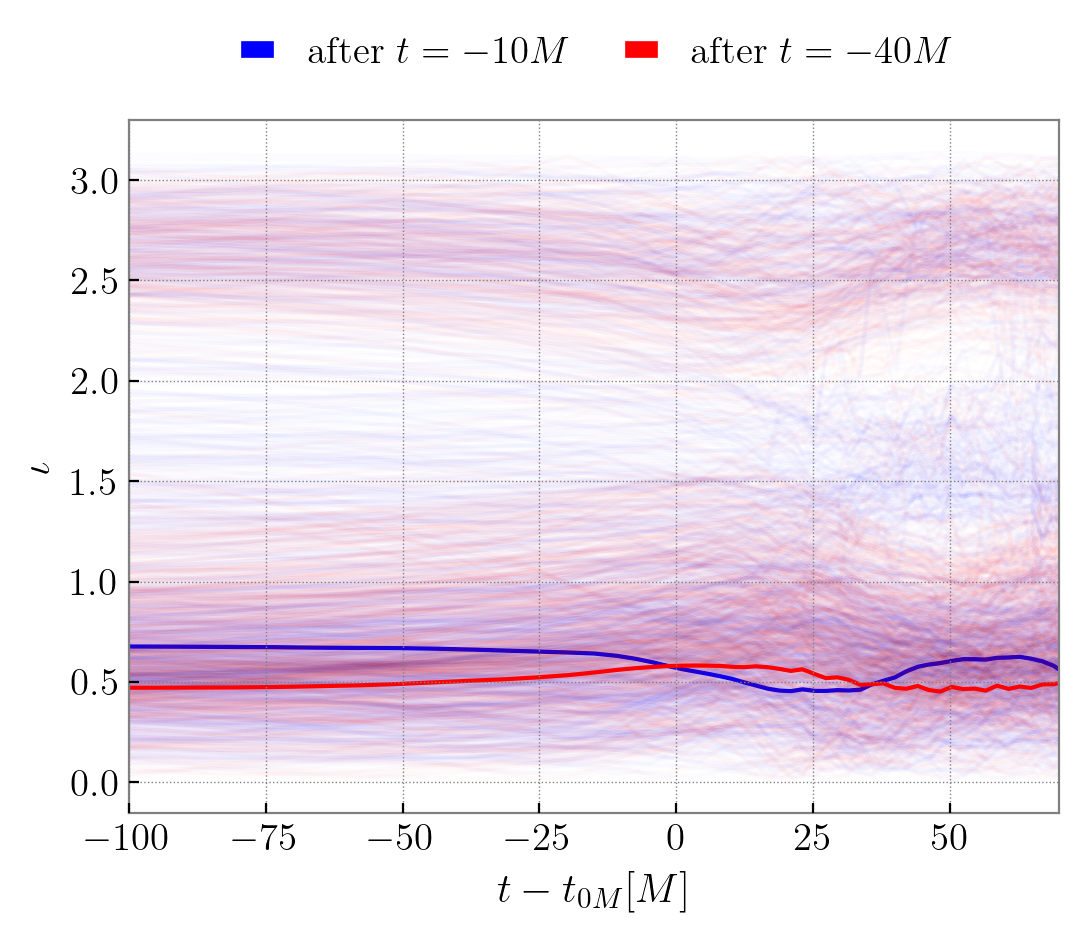

In [29]:
# Make figure
times_to_plot = ['m10M', 'm40M']
n_traces_to_plot = 500

fig, axes = plt.subplots(1, 1)

handles = []

for i,tc in enumerate(times_to_plot): 
    
    # plot all traces
    iota_vs_time = np.asarray(angles_vs_time_dict[f'rd {tc}']['incl_vs_time'])
    time = np.asarray(angles_vs_time_dict[f'rd {tc}']['time_M'])
    axes.plot(time.T, iota_vs_time.T, color=colors[i], alpha=0.01, zorder=0)
    
    # plot maxP trace 
    imax = np.argmax(reconstruction_dict[f'rd {tc}']['params']['ln_posterior'])
    axes.plot(time[imax,:], iota_vs_time[imax,:], color=colors[i], alpha=1, zorder=0)
    
    lbl = tc.replace('m', '-') if tc[0]=='m' else tc
    handles.append(Line2D([], [], color=colors[i],label=f'after $t = {lbl}$'))
    
axes.set_xlim(-100, 70)
axes.set_xlabel(r'$t-t_{0M} [M]$', fontsize=15)
axes.set_ylabel(r'$\iota$', fontsize=15)

axes.legend(handles=handles, fontsize=14, bbox_to_anchor=(0.1, 1.05, 0.8, .102), 
               loc='lower left', ncols=2, mode="expand", borderaxespad=0., frameon=False)

#plt.savefig('figure_04.pdf', bbox_inches='tight')
plt.show()